This notebook inspects the difference between zonally averaged temperature fields obtained by my spherical harmonic averager, and ncremap (at least, some old files that. have ditting around which were produced by ncremap).

I becamse suspicious of the pole beahvior in some remapped data that I have from April. Here, I first check that the pole-point artifacts are clearly visible in a 2D horizontal slice at the model top in the remapped data (they are), and then looked at the same for the native data using a triangualtion-based contouring routine. The artifacts are not present in the native data, and so must have originated in the ncremap interpolation.

I do not know if this was due to a user error when using ncremap (i.e. me), which is possible, since the files were generated a while ago. I have run into issues in the past with a mapping file being bad, and needing to be replaced (Ben Hillman halped me troubleshoot a similar issue in ne30). 

Rather than start the annoying troubleshooting process to understand what happened during the remap, I can instead cross-check the zonal average with one produced from my own spherical-harmonic based tool. After doing this, (*as long as we choose an appropriate L= ~50-100, else the estiamte blows up; see ADMG group meeting research update google slides from 9/26/23. I found by playing around with this that the differences were approximately minimized near L=70, though of course ncremap should not be considered "truth" to minimize against), we see that the pole point artifacts are not here, again confirming the ncremap issue.

I've also checked the difference between my estiamte and ncremaps away from the pole points (interior to +/- 80 degrees), and the agreement is good (max. errors of ~0.2K in the lat-lev plane).

**conclusion: in figures requiring zonal averaging, I will use my own tool, e.g. in HSW_Teq.ipynb**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pdb
import matplotlib.ticker as ticker
from metpy.units import units as u
import metpy.constants as const
from matplotlib.gridspec import GridSpec
import xarray as xr
import sys
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from metpy.units import units as u

from PyTEMDiags import sph_zonal_averager

sys.path.append(os.path.abspath("/global/homes/j/jhollo/repos/climate_util"))
import climate_toolbox as ctb
import artist_utils as au
print('done')

# ---------- matplotlib settings

mpl.rcParams.update(mpl.rcParamsDefault)

SMALL_SIZE = 8
MEDIUM_SIZE = 11
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)

done


(sph_zonal_mean debug) called sph_compute_matrices() for (M x N) = (91 x 6144), L = 70
(sph_zonal_mean debug) building Y0...
(sph_zonal_mean debug) building Y0'...
(sph_zonal_mean debug) inverting Y0...
(sph_zonal_mean debug) elapsed time: 2.52 seconds
(sph_zonal_mean debug) taking Z = Y0*inv(Y0)...
(sph_zonal_mean debug) elapsed time: 0.12 seconds
(sph_zonal_mean debug) Z wrote to file /global/u2/j/jhollo/repos/PyTEMDiags/PyTEMDiags/../maps/Z_ncol6144_L70.nc
(sph_zonal_mean debug) taking Z' = Y0'*inv(Y0)...
(sph_zonal_mean debug) elapsed time: 0.00 seconds
(sph_zonal_mean debug) Zp wrote to file /global/u2/j/jhollo/repos/PyTEMDiags/PyTEMDiags/../maps/Zp_ncol6144_2.0deg_L70.nc
(sph_zonal_mean debug) Reshaped variable T: (6144, 72) -> (6144, 72)
(sph_zonal_mean debug) Taking zonal average of variable T...
(sph_zonal_mean debug) Reshaped zonal mean of variable T: (91, 72) -> (91, 72)
(sph_zonal_mean debug) Reduced ncol of variable T to the zonal-mean grid: ncol=6144 -> ncol91
min-max dif

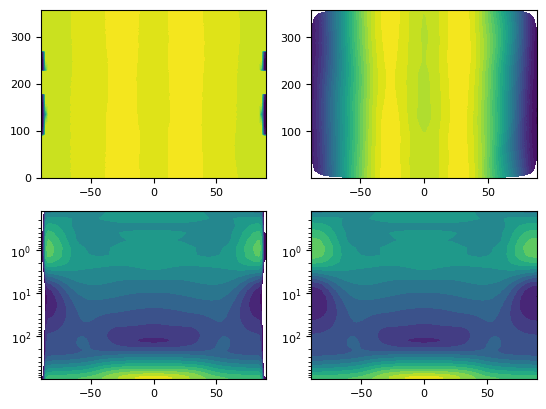

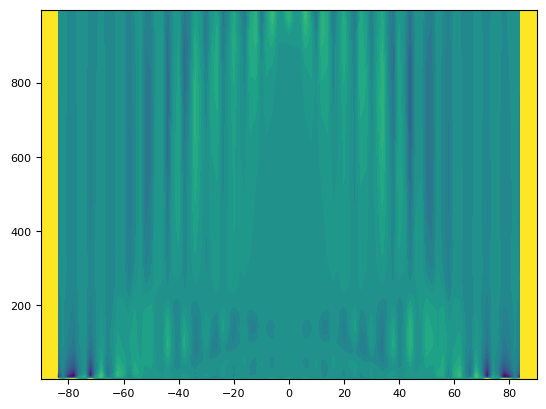

In [10]:
# =====================================
# ====== read sim data ================
dat = '/pscratch/sd/j/jhollo/E3SM/E3SMv2_cases/hsw_cases/E3SM_ne16_L72_FIDEAL_10year_spinup/run/E3SM_ne16_L72_FIDEAL_10year_spinup.eam.h0.0001-01-01-00000.nc.regrid.2x2.nc'
dat = xr.open_dataset(dat)
dat = dat.assign_coords(time = ctb.time2day(dat['time']))
#dat = dat.sel(time = slice(5*365, 11*365)).mean('time').mean('lon')
dat = dat.sel(time = slice(5*365, 11*365)).mean('time')
T = dat['T']
U = dat['U']
datlat = dat['lat']
datlev = dat['lev']
datlon = dat['lon']

dat2 = '/pscratch/sd/j/jhollo/E3SM/E3SMv2_cases/hsw_cases/E3SM_ne16_L72_FIDEAL_10year_spinup/run/E3SM_ne16_L72_FIDEAL_10year_spinup.eam.h0.0001-01-01-00000.nc'
dat2 = xr.open_dataset(dat2)
dat2 = dat2.assign_coords(time = ctb.time2day(dat2['time']))
dat2 = dat2.sel(time = slice(5*365, 11*365)).mean('time')
T2 = dat2['T']
U2 = dat2['U']
dat2lat = dat2['lat']
dat2lev = dat2['lev']
dat2lon = dat2['lon']

zm = sph_zonal_averager(dat2lat, datlat, L=70, debug=True)
zm.sph_compute_matrices()
T2zm = zm.sph_zonal_mean(T2.T)

fig, axes = plt.subplots(2, 2)
axes = np.ravel(axes)
LAT, LON = np.meshgrid(datlat, datlon)
axes[0].contourf(LAT, LON, T.isel(lev=0).T, levels=30)
axes[1].tricontourf(dat2lat, dat2lon, T2.isel(lev=0), levels=30)

LAT, LEV = np.meshgrid(datlat, datlev)
TLEV = np.arange(170, 320, 10)
axes[2].contourf(LAT, LEV, T.mean('lon'), levels=TLEV)
axes[2].invert_yaxis()
axes[2].set_yscale('log')

axes[3].contourf(LAT, LEV, T2zm.T, levels=TLEV)
axes[3].invert_yaxis()
axes[3].set_yscale('log')

plt.figure()
plt.contourf(LAT, LEV, (T2zm.T - T.mean('lon')), levels=np.linspace(-0.25, 0.25, 30), extend='both')

Tdiff = (T2zm.T - T.mean('lon'))
Tdiffi = Tdiff.sel(lat=slice(-80, 80))
Tdiff =Tdiff.values
Tdiffi = Tdiffi.values
print('min-max diff: {:.2f}, {:.2f}'.format(np.min(Tdiff), np.max(Tdiff)))
print('min-max diff excl ploes: {:.2e}, {:.2e}'.format(np.min(Tdiffi), np.max(Tdiffi)))
plt.show()

(sph_zonal_mean debug) Reshaped variable U: (6144, 72) -> (6144, 72)
(sph_zonal_mean debug) Taking zonal average of variable U...
(sph_zonal_mean debug) Reshaped zonal mean of variable U: (91, 72) -> (91, 72)
(sph_zonal_mean debug) Reduced ncol of variable U to the zonal-mean grid: ncol=6144 -> ncol91
min-max diff: -1.56, 3.32
min-max diff excl ploes: -3.76e-01, 3.72e-01


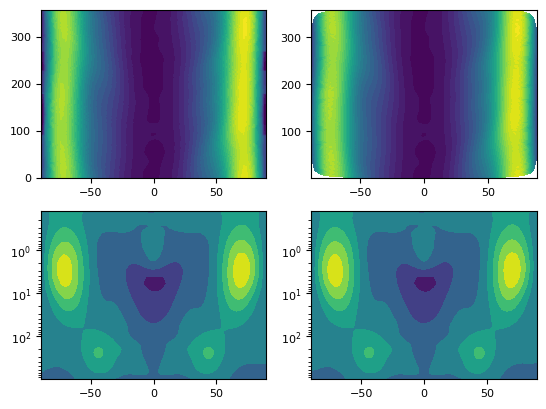

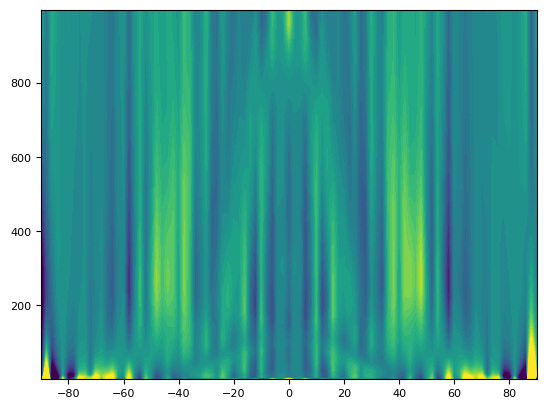

In [11]:
U2zm = zm.sph_zonal_mean(U2.T)

fig, axes = plt.subplots(2, 2)
axes = np.ravel(axes)
LAT, LON = np.meshgrid(datlat, datlon)
axes[0].contourf(LAT, LON, U.isel(lev=0).T, levels=30)
axes[1].tricontourf(dat2lat, dat2lon, U2.isel(lev=0), levels=30)

LAT, LEV = np.meshgrid(datlat, datlev)
TLEV = np.arange(170, 320, 10)
axes[2].contourf(LAT, LEV, U.mean('lon'), levels=8)
axes[2].invert_yaxis()
axes[2].set_yscale('log')

axes[3].contourf(LAT, LEV, U2zm.T, levels=8)
axes[3].invert_yaxis()
axes[3].set_yscale('log')

plt.figure()
plt.contourf(LAT, LEV, (U2zm.T - U.mean('lon')), levels=np.linspace(-0.25, 0.25, 30), extend='both')

Udiff = (U2zm.T - U.mean('lon'))
Udiffi = Udiff.sel(lat=slice(-80, 80))
Udiff =Udiff.values
Udiffi = Udiffi.values
print('min-max diff: {:.2f}, {:.2f}'.format(np.min(Udiff), np.max(Udiff)))
print('min-max diff excl ploes: {:.2e}, {:.2e}'.format(np.min(Udiffi), np.max(Udiffi)))
plt.show()